### Imports

In [211]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Model Persistence
import joblib

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Optimization Libraries
import optuna

# External Dataset Downloading
import opendatasets as od

# Progress Bar
from tqdm import tqdm as notebook_tqdm

# Set Plotting Defaults
sns.set(rc={'figure.figsize': (16, 8)})
sns.set_style("darkgrid")

In [212]:
import os

def list_folders_and_files(directory):
    """
    List all folders, subfolders, and files in the specified directory without duplication.
    
    Args:
        directory (str): The root directory to start listing.
    """
    seen_directories = set()  # To keep track of visited directories
    for root, dirs, files in os.walk(directory):
        # Avoid duplicate directories
        if root in seen_directories:
            continue
        seen_directories.add(root)

        # Calculate the indentation level for the folder hierarchy
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")  # Print folder name
        
        # Print files in the current directory
        sub_indent = ' ' * 4 * (level + 1)
        for f in sorted(files):  # Sort files alphabetically
            print(f"{sub_indent}{f}")
        # Sort directories alphabetically to avoid potential reordering
        dirs.sort()

# Specify the root directory of your project
project_directory = input("Enter the path to your project directory: ")
list_folders_and_files(project_directory)


## Data Loading and Preprocessing

In [16]:
# Define the desired path for the raw data folder
raw_data_folder = r"C:\Users\User\ml-zoomcamp\capstone_1\data\raw"

# Ensure the raw data folder exists
os.makedirs(raw_data_folder, exist_ok=True)

# Download the dataset into the raw data folder
dataset_url = 'https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/data'
od.download(dataset_url, data_dir=raw_data_folder)

print(f"Dataset downloaded and stored in: {raw_data_folder}")

Skipping, found downloaded files in "C:\Users\User\ml-zoomcamp\capstone_1\data\raw\air-quality-and-pollution-assessment" (use force=True to force download)
Dataset downloaded and stored in: C:\Users\User\ml-zoomcamp\capstone_1\data\raw


In [161]:
# Load the dataset
df = pd.read_csv(r"C:\Users\User\ml-zoomcamp\capstone_1\data\raw\air-quality-and-pollution-assessment\updated_pollution_dataset.csv")
df.head()

Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good

In [162]:
# Check the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [163]:
# Check for missing values
df.isnull().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

No missing values.

In [164]:
# Transform column names: make lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

Index(['temperature', 'humidity', 'pm2.5', 'pm10', 'no2', 'so2', 'co',
       'proximity_to_industrial_areas', 'population_density', 'air_quality'],
      dtype='object')

## Exploratory Data Analysis (EDA)

In [165]:
# Check basic information about registration_data_test dataset
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print('='*40)
print ("Features : \n" ,df.columns.tolist())
print('='*40)
print ("Unique values :  \n",df.nunique())

Rows     :  5000
Columns  :  10
Features : 
 ['temperature', 'humidity', 'pm2.5', 'pm10', 'no2', 'so2', 'co', 'proximity_to_industrial_areas', 'population_density', 'air_quality']
Unique values :  
 temperature                      362
humidity                         723
pm2.5                            815
pm10                             955
no2                              445
so2                              348
co                               265
proximity_to_industrial_areas    179
population_density               683
air_quality                        4
dtype: int64


In [166]:
# Check summary statistics
df.describe().T

count        mean         std     min     25%  \
temperature                    5000.0   30.029020    6.720661   13.40   25.10   
humidity                       5000.0   70.056120   15.863577   36.00   58.30   
pm2.5                          5000.0   20.142140   24.554546    0.00    4.60   
pm10                           5000.0   30.218360   27.349199   -0.20   12.30   
no2                            5000.0   26.412100    8.895356    7.40   20.10   
so2                            5000.0   10.014820    6.750303   -6.20    5.10   
co                             5000.0    1.500354    0.546027    0.65    1.03   
proximity_to_industrial_areas  5000.0    8.425400    3.610944    2.50    5.40   
population_density             5000.0  497.423800  152.754084  188.00  381.00   

                                  50%      75%     max  
temperature                     29.00   34.000   58.60  
humidity                        69.80   80.300  128.10  
pm2.5                           12.00   26.100  295.00  
pm10                            21.70   38.100  315.80  
no2                             25.30   31.900   64.90  
so2                              8.00   13.725   44.90  
co                               1.41    1.840    3.72  
proximity_to_industrial_areas    7.90   11.100   25.80  
population_density             494.00  600.000  957.00

In [167]:
# Plot distributions for numerical features
def plot_distributions(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.histplot(data[feature], kde=True, bins=30)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.show()

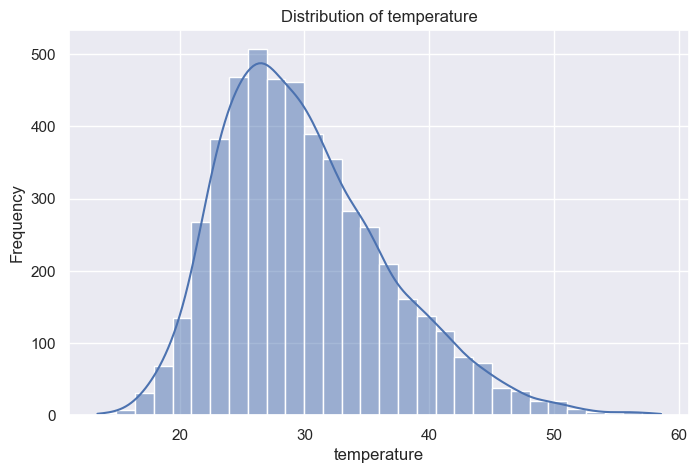

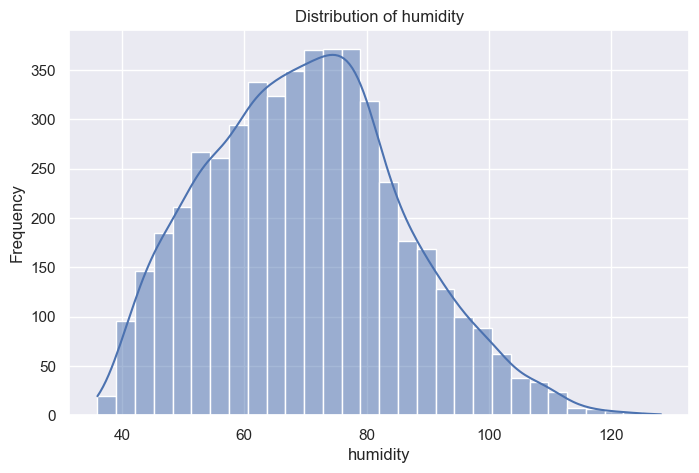

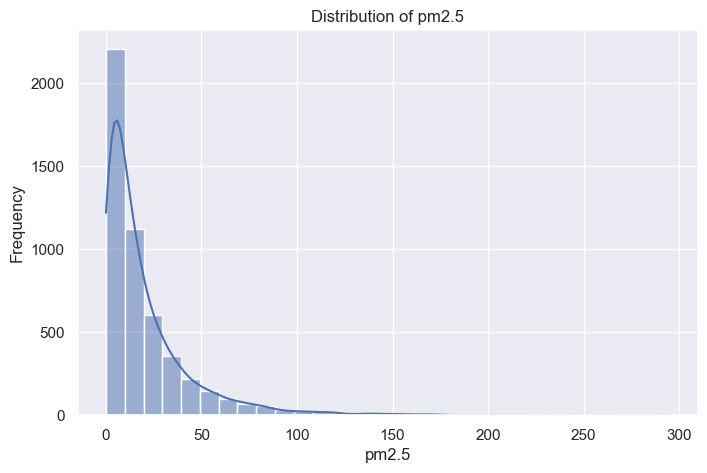

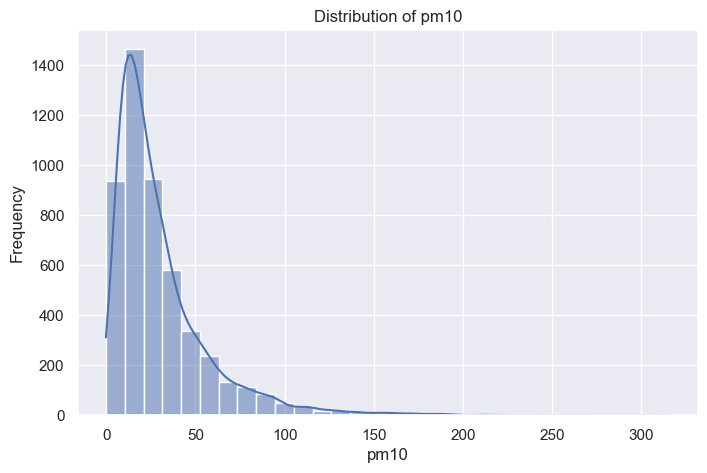

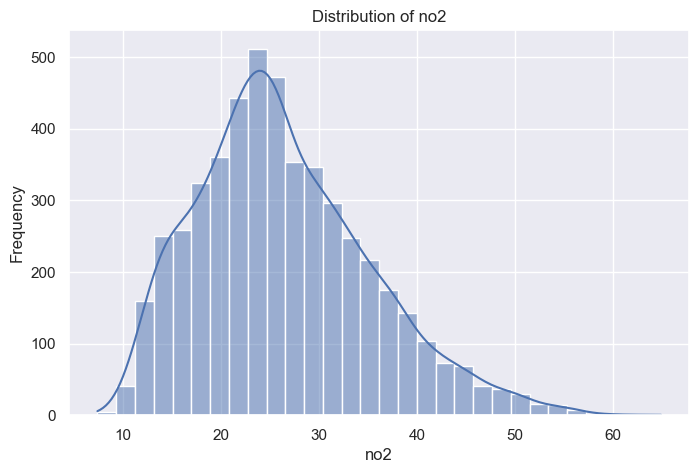

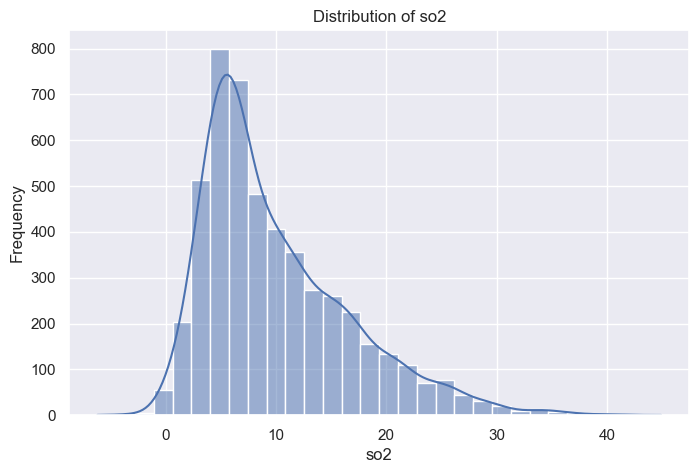

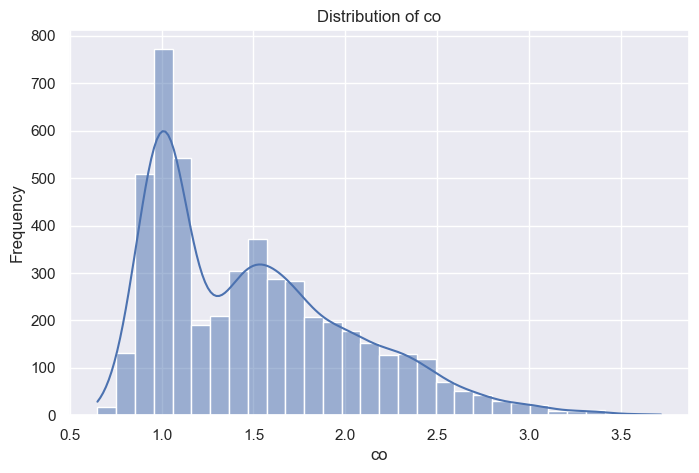

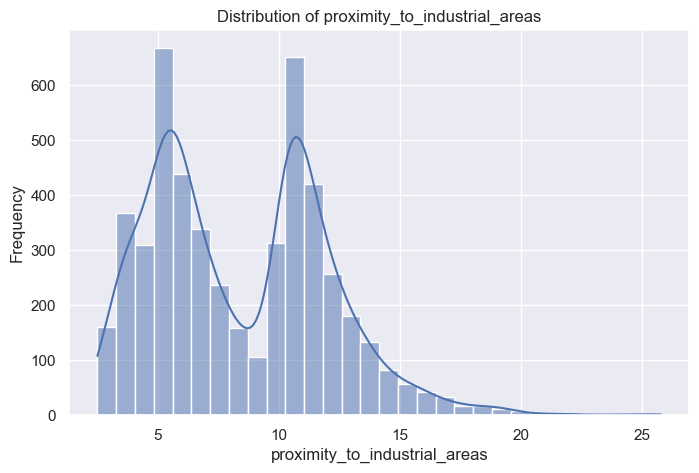

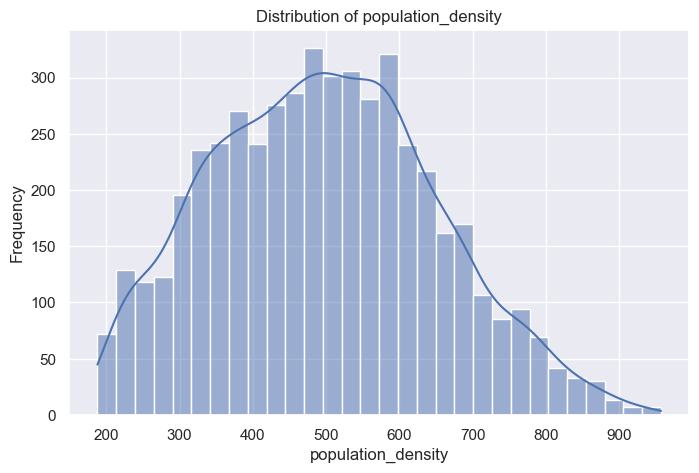

In [168]:
# Select numerical features for visualization
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
plot_distributions(df, numerical_features)


In [169]:
# Bar plot for categorical features
def plot_categorical_distribution(data, feature):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, data=data) 
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

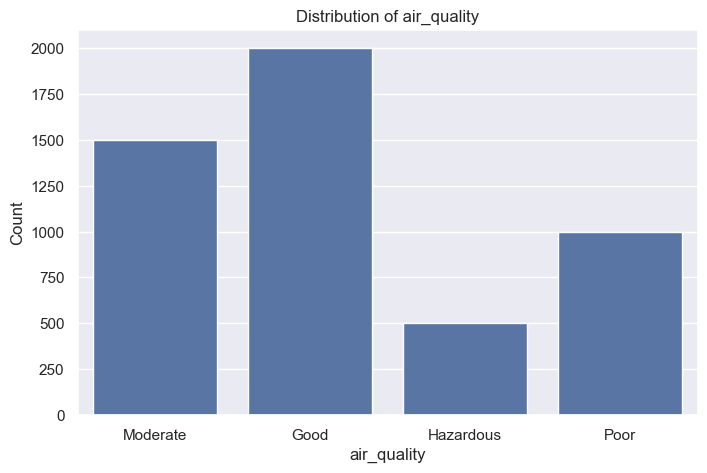

In [170]:
# Plot categorical features
categorical_features = df.select_dtypes(include=[object]).columns.tolist()
for feature in categorical_features:
    plot_categorical_distribution(df, feature)

This is our target variable.

In [171]:
# Check the distribution of the target variable
air_quality_count = df['air_quality'].value_counts()
air_quality_count

air_quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

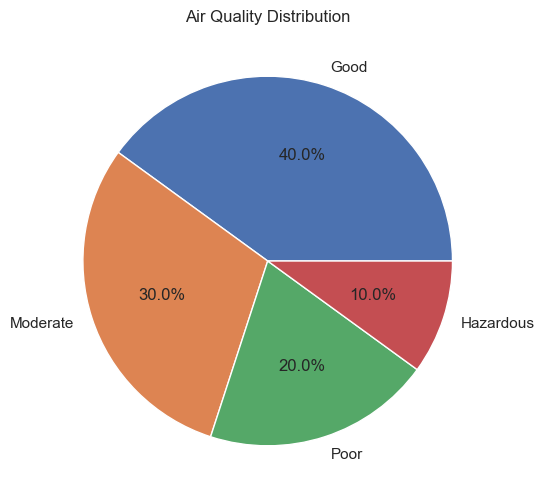

In [172]:
# Proportions of air quality levels
air_quality_proportions = df['air_quality'].value_counts(normalize=True)
air_quality_proportions.plot.pie(autopct="%.1f%%", figsize=(6, 6), title="Air Quality Distribution")
plt.ylabel("")
plt.show()


In [173]:
# Plot boxplots for numerical features to identify outliers
def plot_boxplots(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=data[feature])
        plt.title(f"Boxplot of {feature}")
        plt.xlabel(feature)
        plt.show()

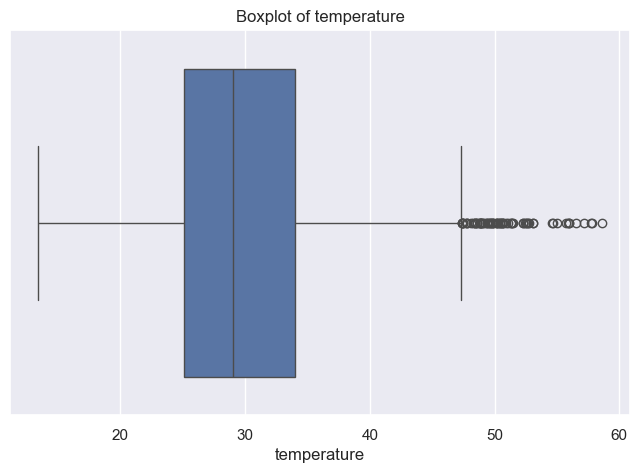

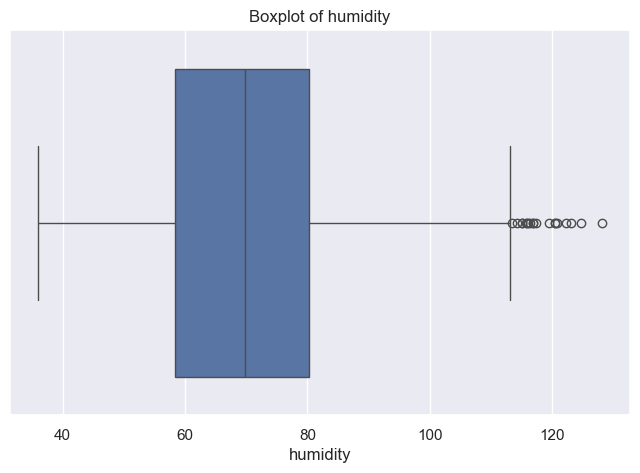

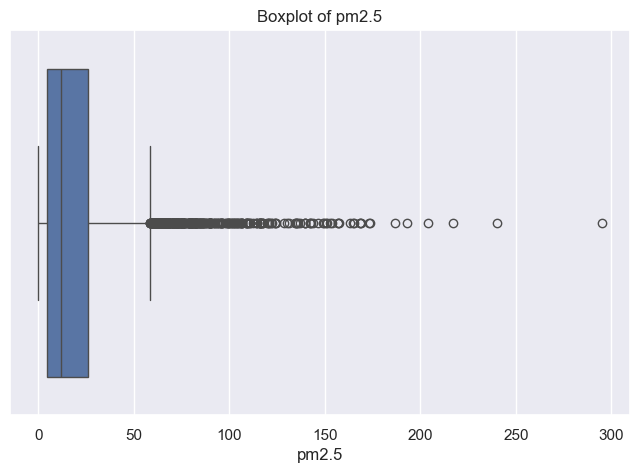

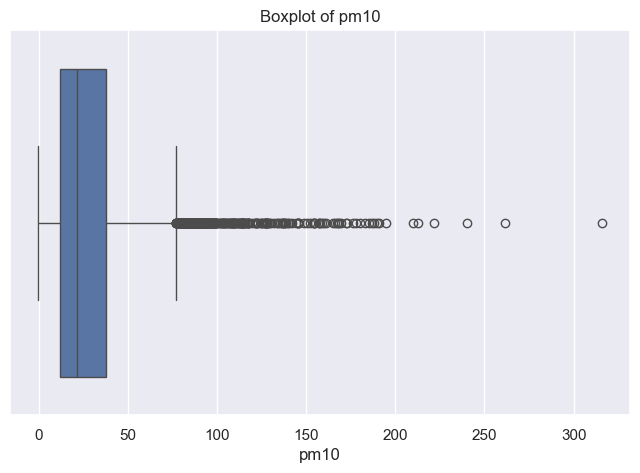

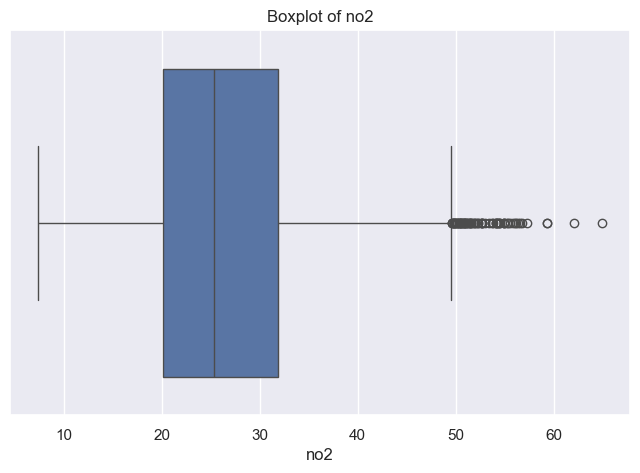

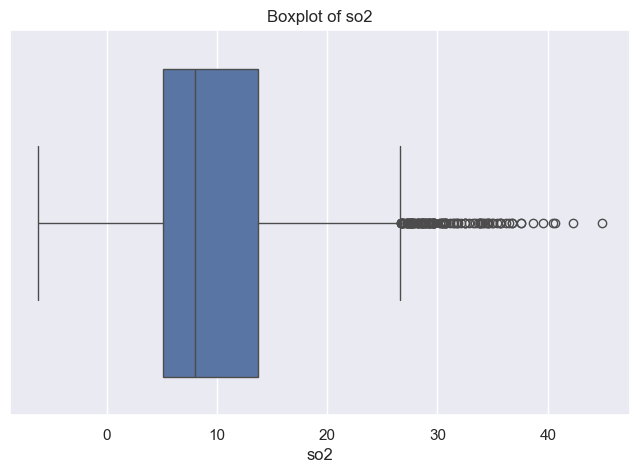

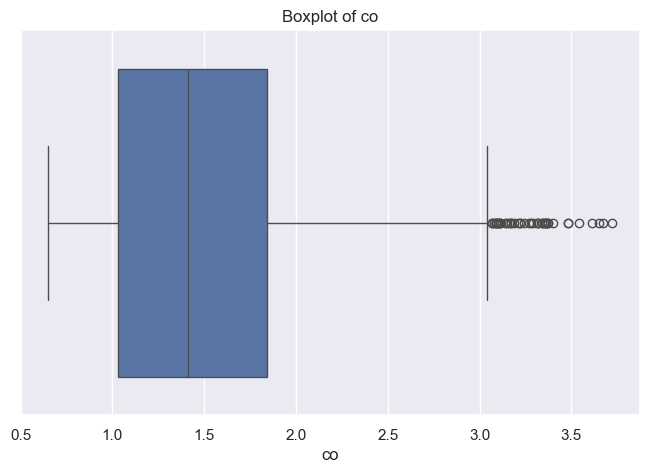

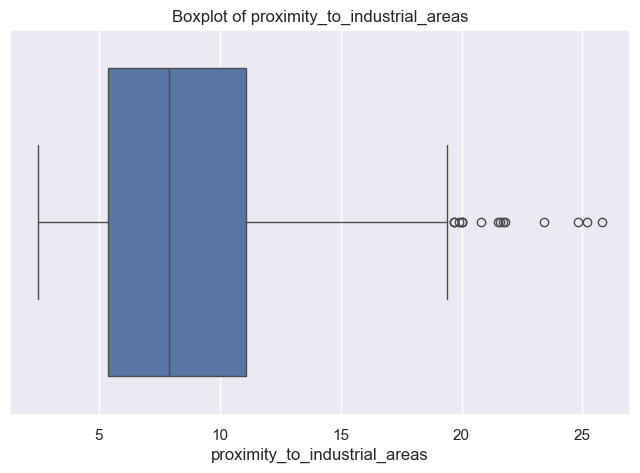

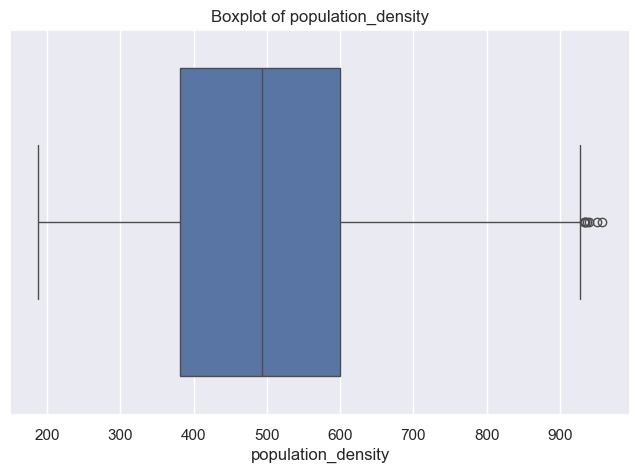

In [174]:
# Plot the boxplots
plot_boxplots(df, numerical_features)

In [175]:
# Selecting only numerical columns
numerical_columns = df.select_dtypes(include=[np.number])

In [176]:
# Calculating the Interquartile Range (IQR) for each numerical column
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding outliers by checking if values fall outside the bounds
outliers = (numerical_columns < lower_bound) | (numerical_columns > upper_bound)

# Printing outliers for each numerical column
for column in outliers.columns:
    print(f"Outliers in {column}:")
    print(df[outliers[column]][column])
    print()

Outliers in temperature:
29      52.5
55      48.1
67      58.6
106     49.6
249     50.9
        ... 
4664    49.1
4814    52.6
4892    50.2
4938    48.8
4945    47.5
Name: temperature, Length: 72, dtype: float64

Outliers in humidity:
509     120.5
865     116.9
960     115.0
1304    116.1
1892    115.7
2209    120.5
2278    128.1
2391    113.5
2957    116.9
3316    116.3
3397    117.3
3455    115.0
3474    120.7
3559    119.4
3693    124.7
3827    115.9
4275    122.3
4371    114.3
4815    123.0
Name: humidity, dtype: float64

Outliers in pm2.5:
29       67.5
33       84.4
35       83.3
42       68.9
49       70.7
        ...  
4960     71.6
4981     62.1
4986     74.5
4995    116.0
4999     81.7
Name: pm2.5, Length: 352, dtype: float64

Outliers in pm10:
29       91.2
33       94.4
35       93.5
42       85.2
49       84.8
        ...  
4955     87.6
4981     79.4
4986     93.3
4995    126.7
4999     94.3
Name: pm10, Length: 324, dtype: float64

Outliers in no2:
176     50.9
213    

In [177]:
# Calculating the number of outliers in each numerical column
num_outliers = outliers.sum()

# Computing the percentage of outliers in each numerical column
total_rows = df.shape[0]
percentage_outliers = (num_outliers / total_rows) * 100

# Creating a DataFrame to store the results
outlier_stats = pd.DataFrame({
    'Num_Outliers': num_outliers,
    'Percentage_Outliers': percentage_outliers
})

# Displaying the outlier statistics
print("Outlier Statistics:")
print(outlier_stats)

Outlier Statistics:
                               Num_Outliers  Percentage_Outliers
temperature                              72                 1.44
humidity                                 19                 0.38
pm2.5                                   352                 7.04
pm10                                    324                 6.48
no2                                      73                 1.46
so2                                     124                 2.48
co                                       45                 0.90
proximity_to_industrial_areas            16                 0.32
population_density                        7                 0.14


In [178]:
# Function to visualize outliers
def visualize_outliers(data, column, lower_bound, upper_bound):
    plt.figure(figsize=(12, 6))

    # Scatter plot to show outliers
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=data.index, y=data[column], color="blue")
    plt.axhline(lower_bound[column], color="red", linestyle="--", label="Lower Bound")
    plt.axhline(upper_bound[column], color="green", linestyle="--", label="Upper Bound")
    plt.title(f"Scatter Plot of {column} (with Outliers)")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()

    # Boxplot to visualize outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color="lightblue")
    plt.title(f"Boxplot of {column}")

    plt.tight_layout()
    plt.show()

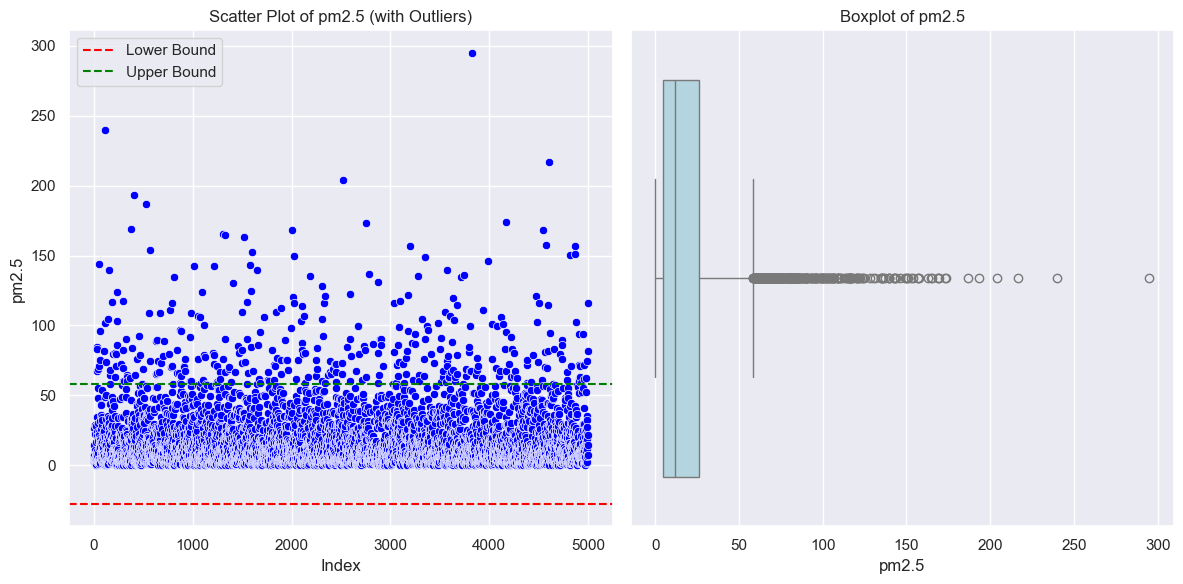

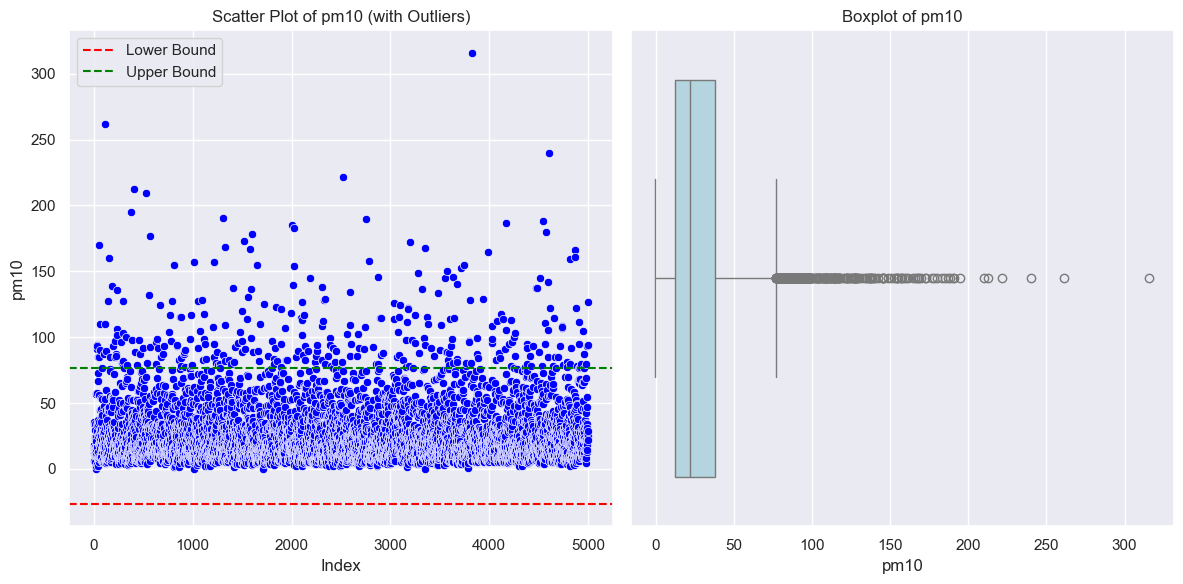

In [179]:
# Visualize outliers for affected columns
for col in ['pm2.5', 'pm10']:
    visualize_outliers(df, col, lower_bound, upper_bound)

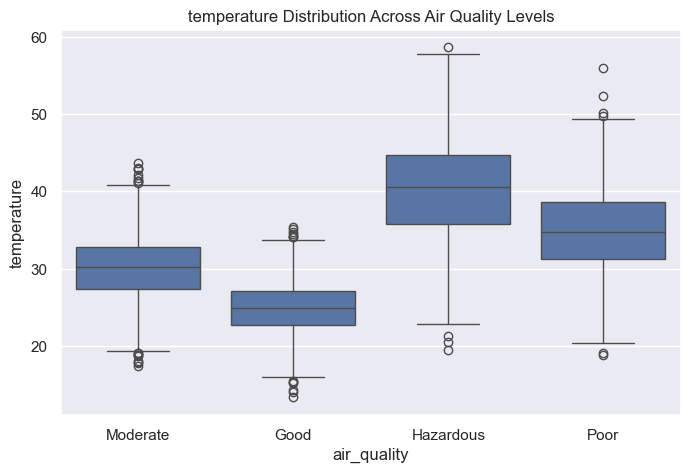

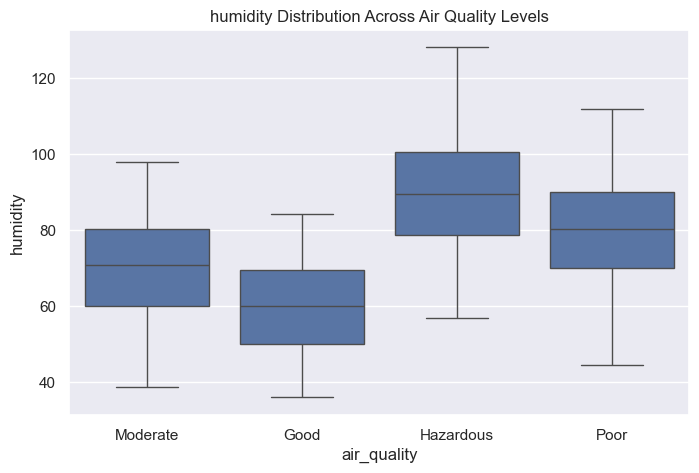

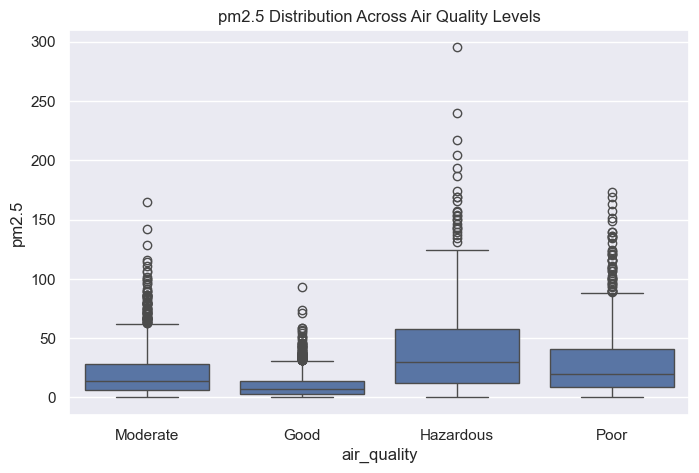

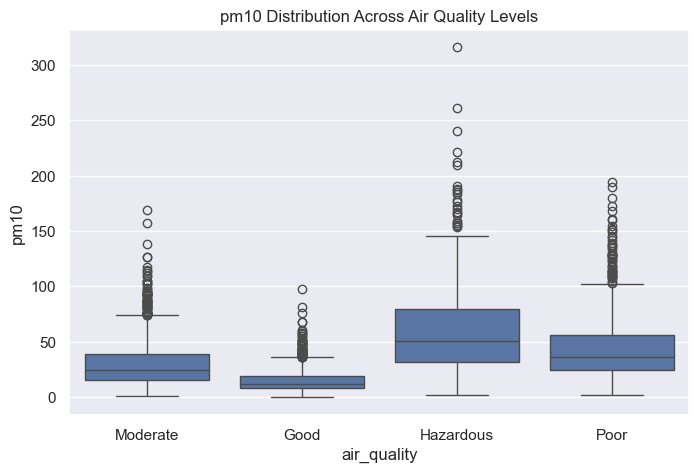

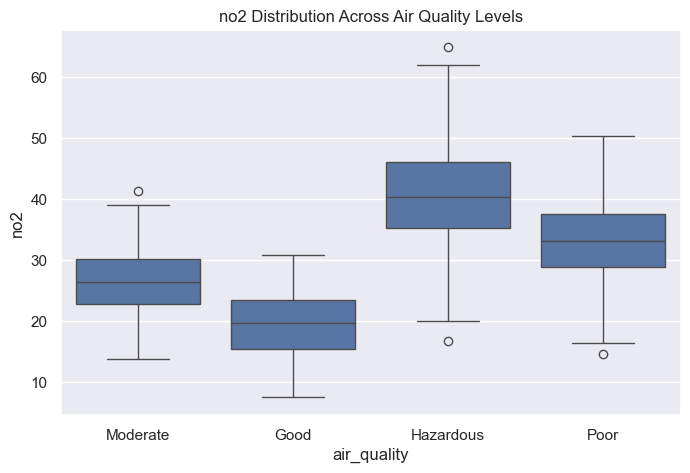

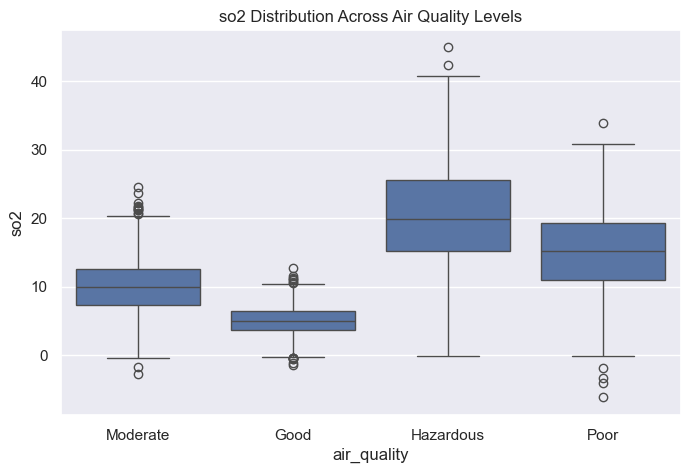

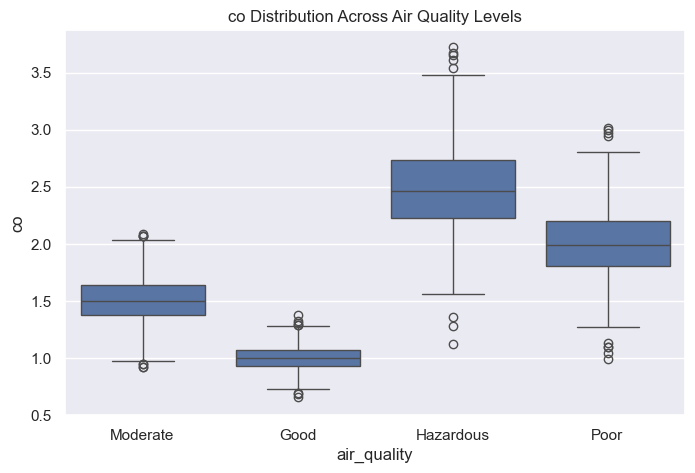

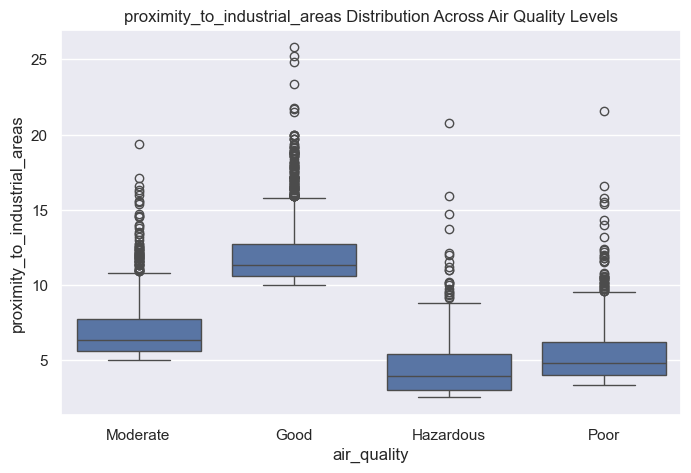

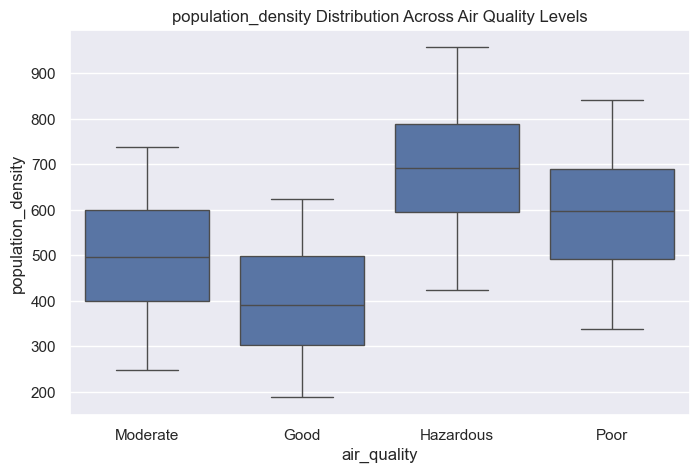

In [180]:
# Boxplots to compare numerical features across air quality levels
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="air_quality", y=feature)
    plt.title(f"{feature} Distribution Across Air Quality Levels")
    plt.show()


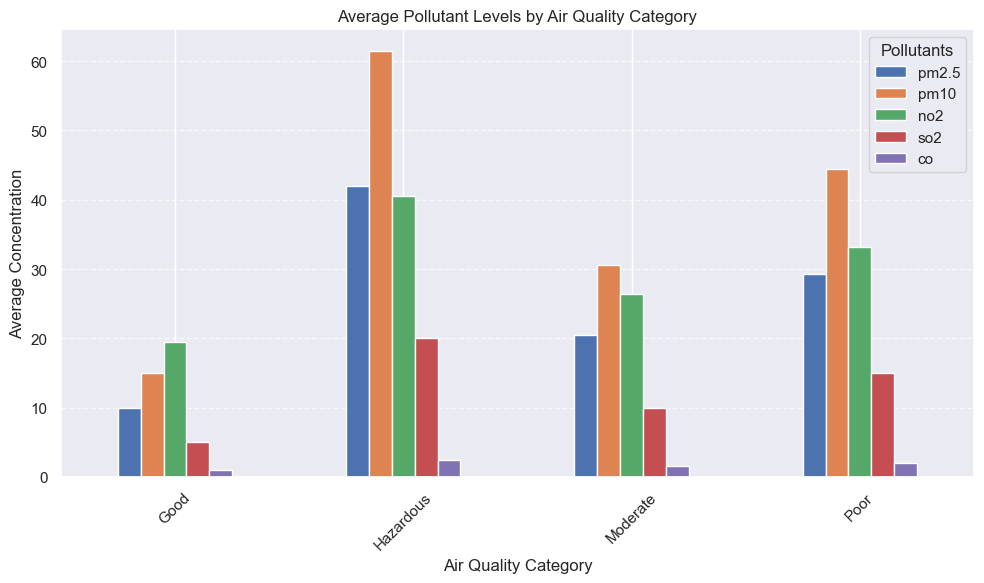

In [181]:
# Select pollutant features
pollutant_features = ['pm2.5', 'pm10', 'no2', 'so2', 'co']

# Calculate the average of pollutants by air quality
avg_pollutants = df.groupby('air_quality')[pollutant_features].mean()

# Plotting the average pollutant levels
avg_pollutants.plot(kind='bar', figsize=(10, 6))
plt.title("Average Pollutant Levels by Air Quality Category")
plt.xlabel("Air Quality Category")
plt.ylabel("Average Concentration")
plt.legend(title="Pollutants")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

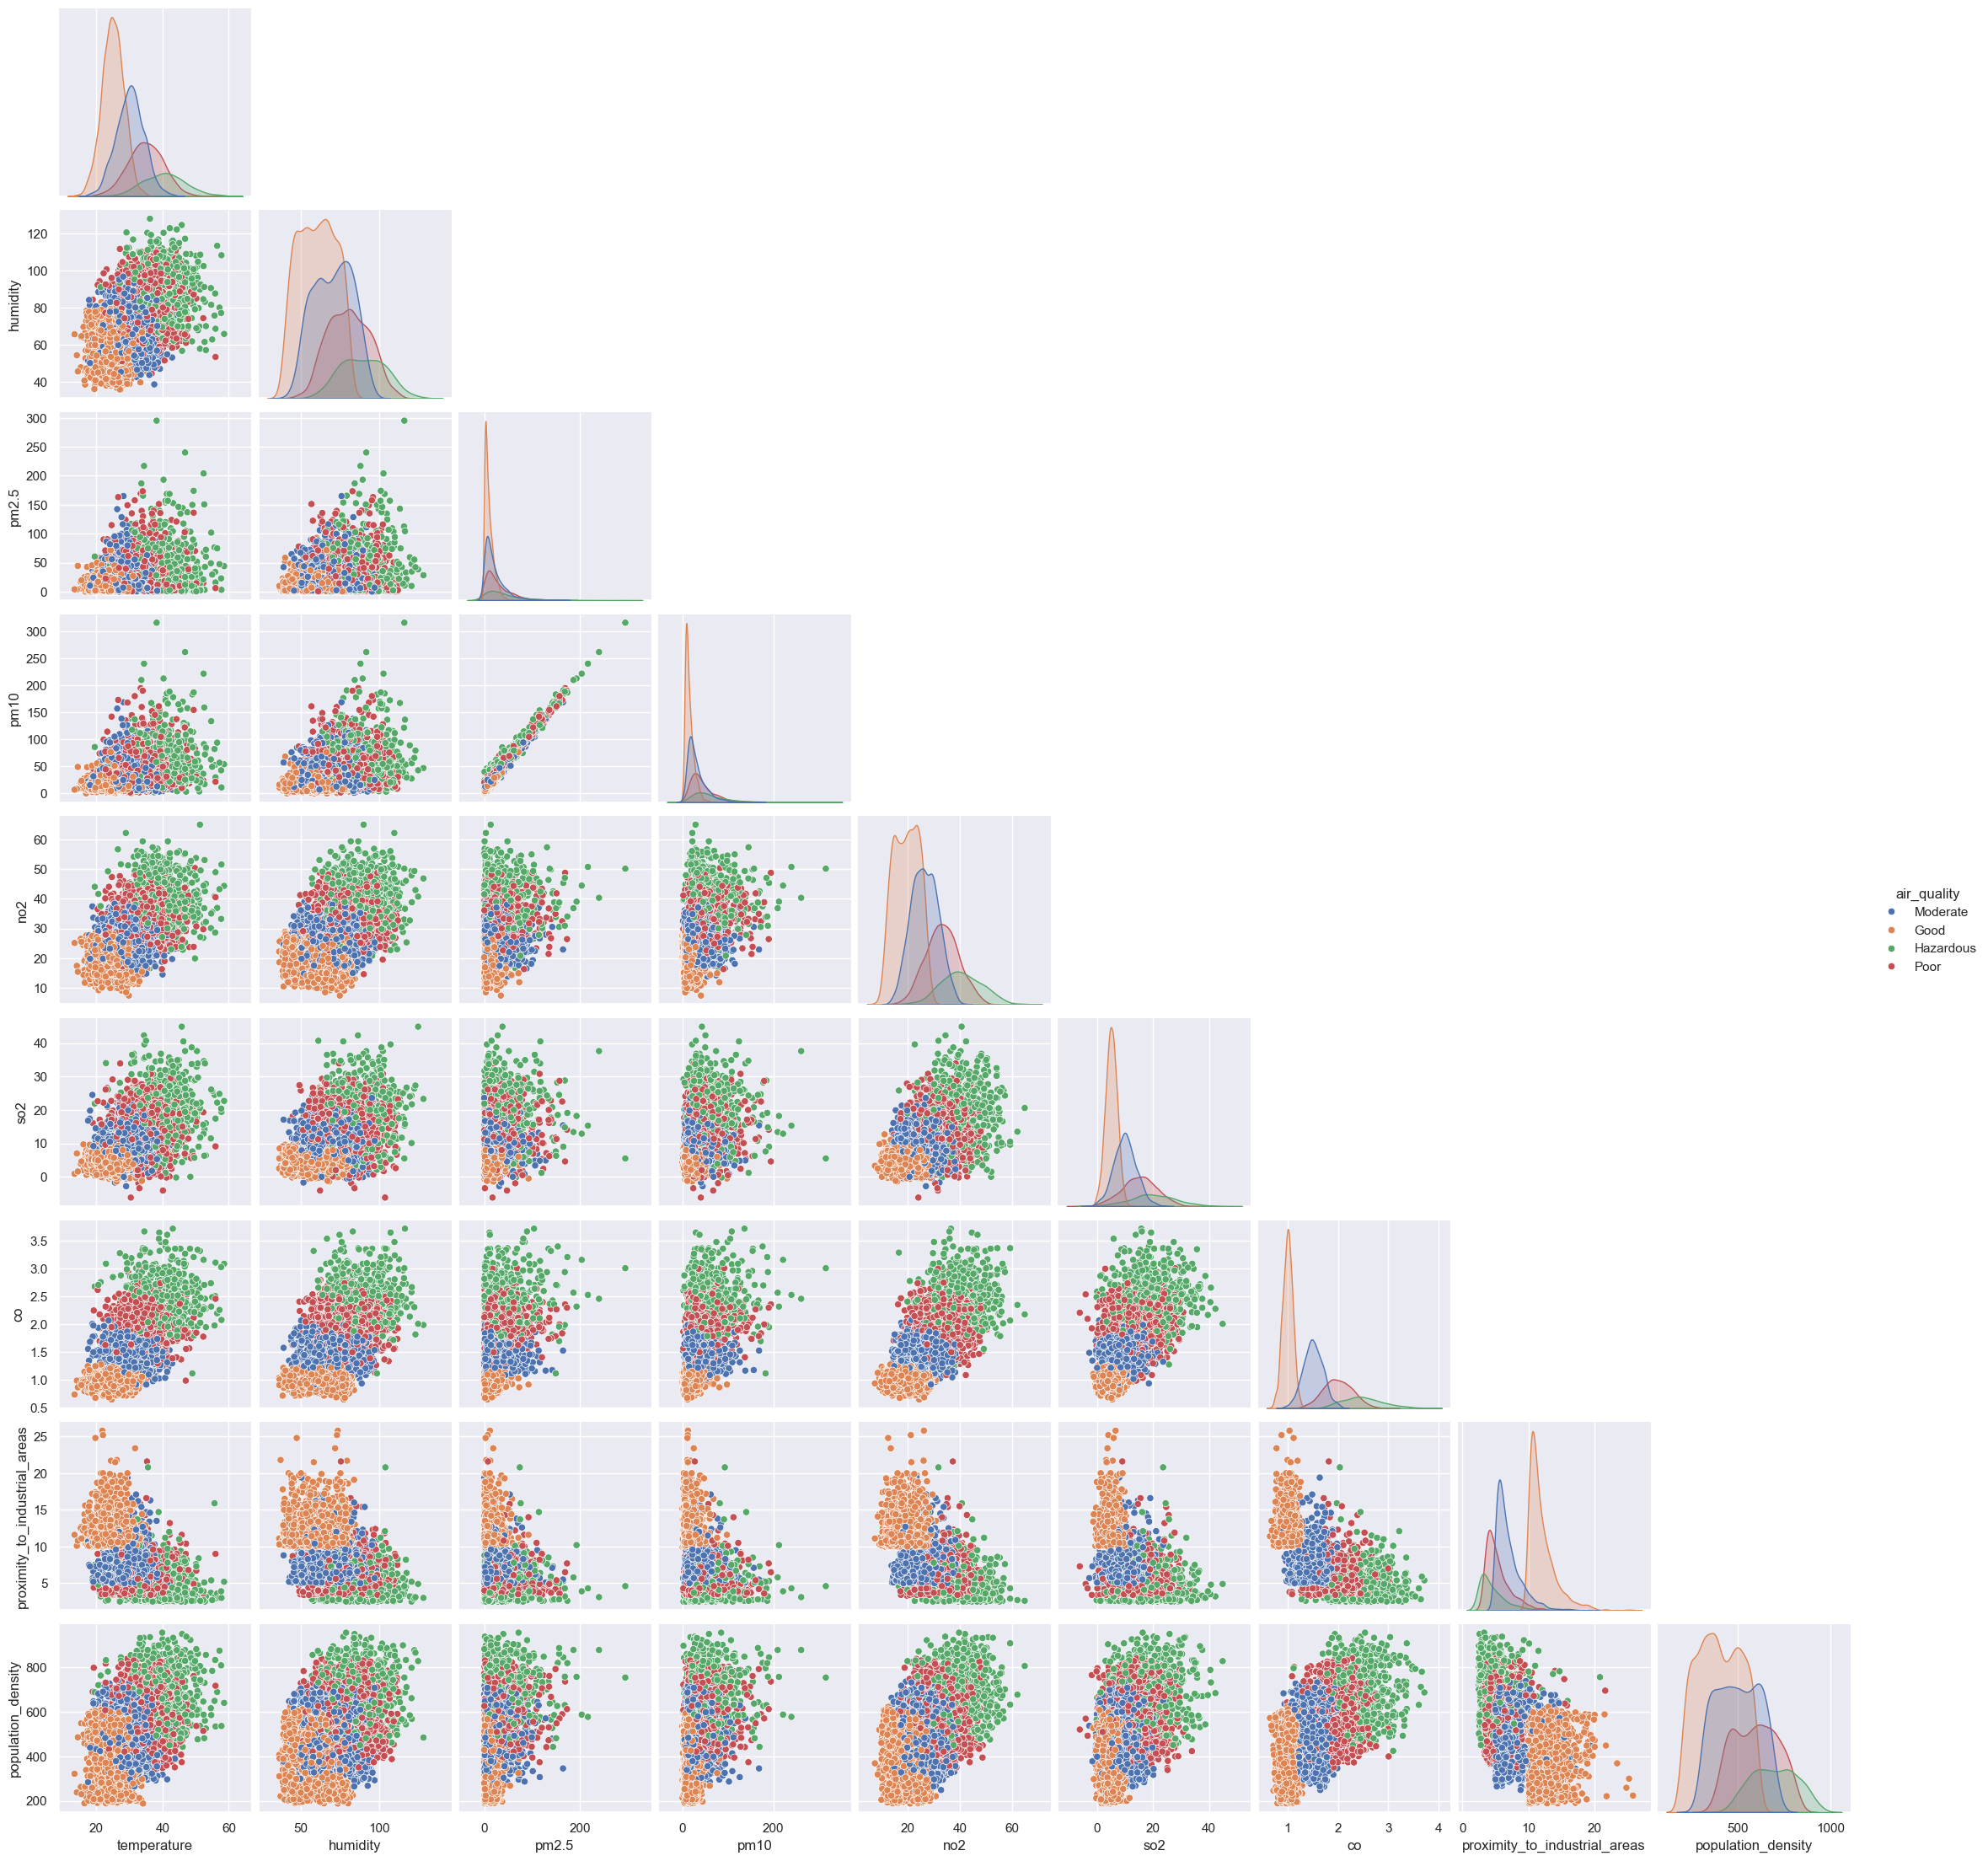

In [182]:
# Pairwise scatter plot with KDEs on the diagonal
sns.pairplot(df, hue="air_quality", diag_kind="kde", corner=True)
plt.show()


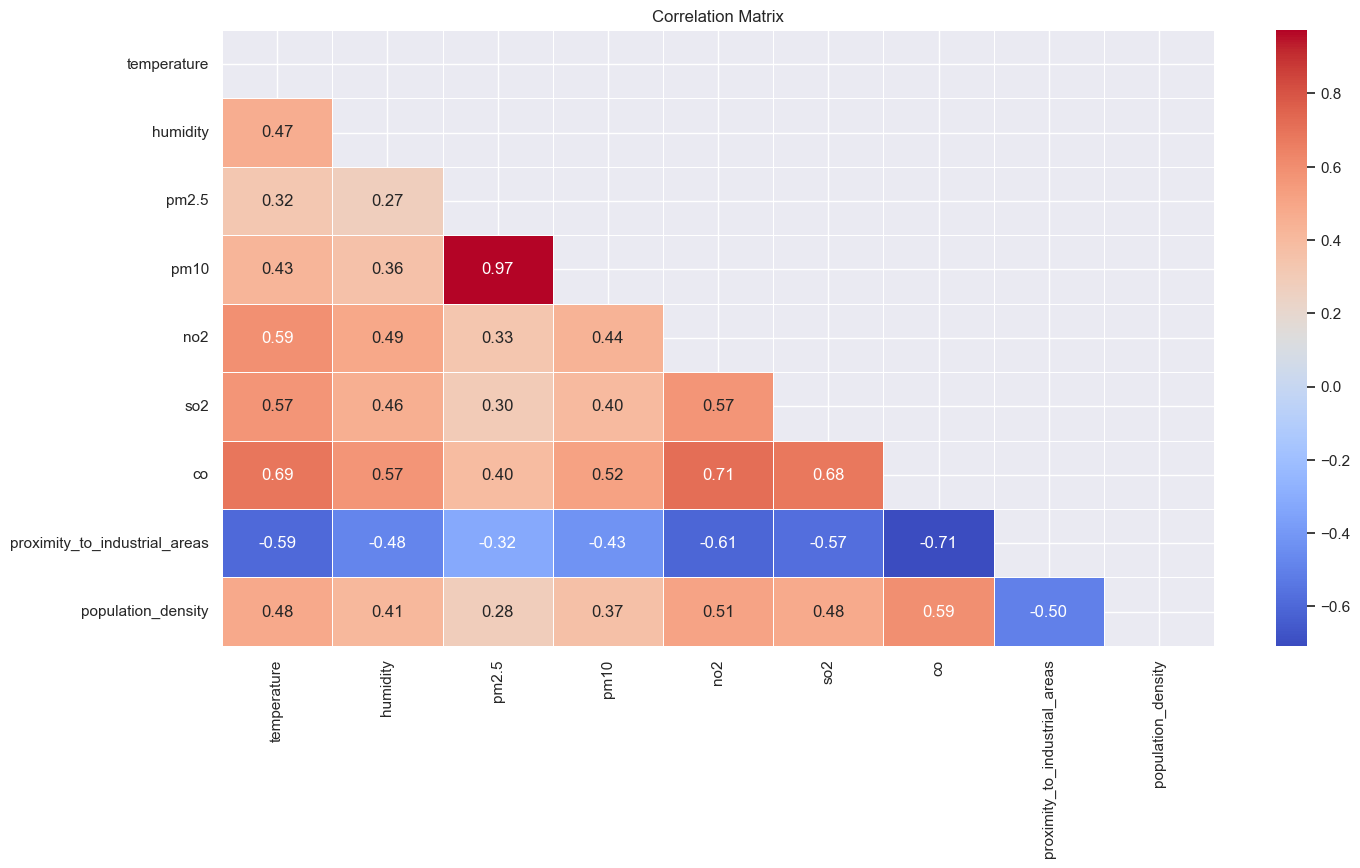

In [183]:
# Correlation Analysis
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [184]:
# Identify key correlated pairs (threshold > 0.8 for strong correlation)
correlation_threshold = 0.8
key_correlated_pairs = []

# Iterate over the correlation matrix and find pairs above the threshold
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            feature_1 = correlation_matrix.index[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            key_correlated_pairs.append((feature_1, feature_2, correlation_value))

# Convert to DataFrame for better readability and display
key_correlated_pairs_df = pd.DataFrame(key_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
key_correlated_pairs_df = key_correlated_pairs_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

key_correlated_pairs_df

Feature 1 Feature 2  Correlation
0     pm2.5      pm10     0.973005

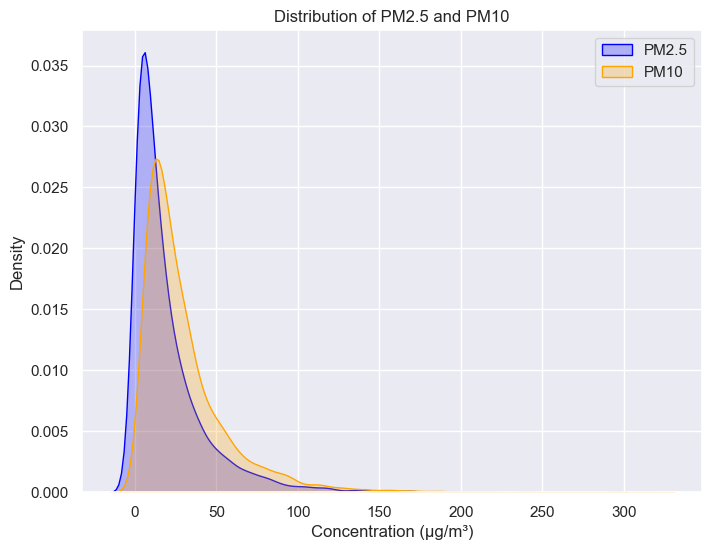

In [185]:
# KDE Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(df['pm2.5'], fill=True, label='PM2.5', color='blue')
sns.kdeplot(df['pm10'], fill=True, label='PM10', color='orange')
plt.title("Distribution of PM2.5 and PM10")
plt.xlabel("Concentration (µg/m³)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [186]:
def correlation_ratio(categories, values):
    """
    Calculate the correlation ratio (eta-squared) for a categorical target and numerical features.

    Args:
        categories (pd.Series or array-like): Categorical target variable.
        values (pd.Series or array-like): Numerical feature variable.
    
    Returns:
        float: Correlation ratio value.
    """
    categories = np.array(categories)
    values = np.array(values)
    overall_mean = np.mean(values)
    category_means = [np.mean(values[categories == category]) for category in np.unique(categories)]
    category_sizes = [np.sum(categories == category) for category in np.unique(categories)]

    between_group_variance = sum(size * (mean - overall_mean) ** 2 for size, mean in zip(category_sizes, category_means))
    total_variance = np.sum((values - overall_mean) ** 2)
    
    return between_group_variance / total_variance if total_variance > 0 else 0

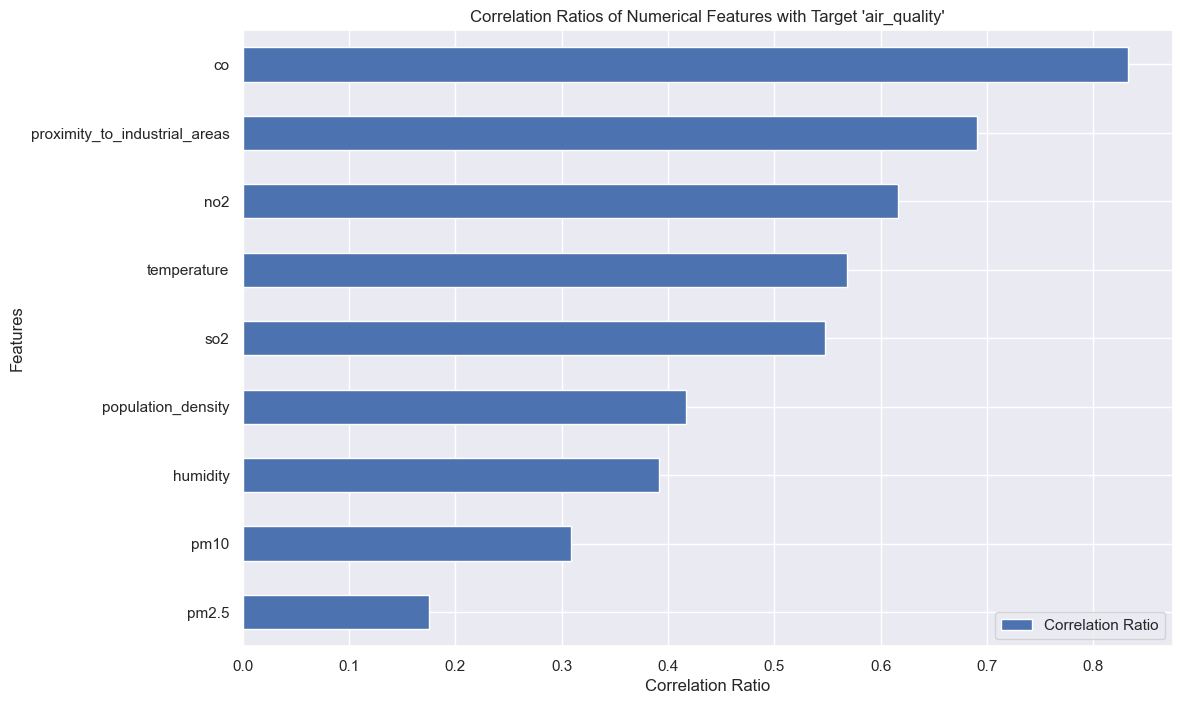

In [187]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
correlation_ratios = {}

for feature in numerical_features:
    correlation_ratios[feature] = correlation_ratio(df['air_quality'], df[feature])

# Convert to DataFrame for Sorting and Visualization
correlation_ratios_df = pd.DataFrame.from_dict(correlation_ratios, orient='index', columns=['Correlation Ratio'])
correlation_ratios_sorted = correlation_ratios_df.sort_values(by='Correlation Ratio', ascending=True)

# Plot the Correlation Ratios
correlation_ratios_sorted.plot(kind='barh', figsize=(12, 8))
plt.title("Correlation Ratios of Numerical Features with Target 'air_quality'")
plt.xlabel("Correlation Ratio")
plt.ylabel("Features")
plt.show()

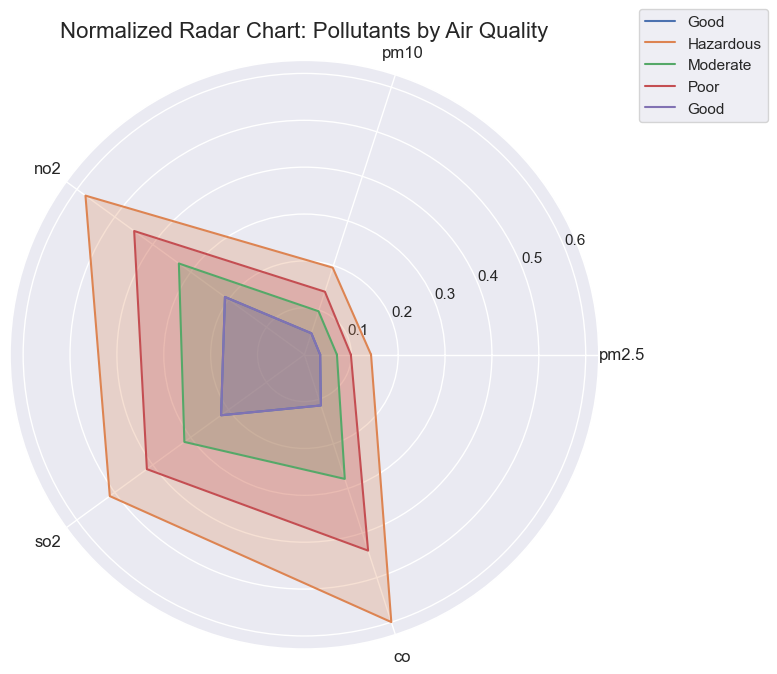

In [ ]:
# Normalize the pollutant features
scaler = MinMaxScaler()
normalized_pollutants = pd.DataFrame(
    scaler.fit_transform(df[pollutant_features]),
    columns=pollutant_features,
    index=df.index
)

# Calculate the mean of normalized pollutants by air quality
avg_normalized_pollutants = (
    normalized_pollutants.join(df['air_quality'])
    .groupby('air_quality')
    .mean()
)

# Prepare data for radar chart
categories = avg_normalized_pollutants.columns
num_vars = len(categories)

# Add a row to close the circle for radar chart
avg_normalized_pollutants = pd.concat([avg_normalized_pollutants, avg_normalized_pollutants.iloc[[0]]])

# Create radar chart
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(polar=True))

# Create radar chart for each air quality category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

for air_quality, row in avg_normalized_pollutants.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=air_quality)
    ax.fill(angles, values, alpha=0.25)

# Customize the chart
ax.set_title("Normalized Radar Chart: Pollutants by Air Quality", size=16)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [189]:
# Dropping the 'pm2.5' feature
df = df.drop(columns=['pm2.5'])

In [190]:
# Check the column names
df.columns

Index(['temperature', 'humidity', 'pm10', 'no2', 'so2', 'co',
       'proximity_to_industrial_areas', 'population_density', 'air_quality'],
      dtype='object')

## Feature Engineering

In [191]:
# Label encoding the target variable 'air_quality'
le = LabelEncoder()
df['air_quality_encoded'] = le.fit_transform(df['air_quality'])

# Define feature set (X) and target variable (y)
X = df.drop(columns=['air_quality', 'air_quality_encoded'])
y = df['air_quality_encoded']

In [205]:
# Save the LabelEncoder
label_encoder_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\label_encoder.pkl"
joblib.dump(le, label_encoder_path)

print(f"LabelEncoder saved at: {label_encoder_path}")

LabelEncoder saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\label_encoder.pkl


In [192]:
# Split into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Identify numerical features for scaling
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Fit the scaler on the training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Apply the scaler to validation and test sets
X_val_scaled = X_val.copy()
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [193]:
# Save the scaler for later use
scaler_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved at: {scaler_path}")

# Check the scaled training data
print("\nShape of scaled training data:", X_train_scaled.shape)

# Check the scaled validation data
print("Shape of scaled validation data:", X_val_scaled.shape)

# Check the scaled test data
print("Shape of scaled test data:", X_test_scaled.shape)

Scaler saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\scaler.pkl

Shape of scaled training data: (3000, 8)
Shape of scaled validation data: (1000, 8)
Shape of scaled test data: (1000, 8)


In [194]:
# Define the desired path for the processed data folder
processed_data_folder = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed"

# Ensure the processed data folder exists
os.makedirs(processed_data_folder, exist_ok=True)

# Save the datasets as CSV files
X_train_scaled.to_csv(os.path.join(processed_data_folder, "X_train_scaled.csv"), index=False)
y_train.to_csv(os.path.join(processed_data_folder, "y_train.csv"), index=False)

X_val_scaled.to_csv(os.path.join(processed_data_folder, "X_val_scaled.csv"), index=False)
y_val.to_csv(os.path.join(processed_data_folder, "y_val.csv"), index=False)

X_test_scaled.to_csv(os.path.join(processed_data_folder, "X_test_scaled.csv"), index=False)
y_test.to_csv(os.path.join(processed_data_folder, "y_test.csv"), index=False)

print("Processed datasets saved successfully in:", processed_data_folder)

Processed datasets saved successfully in: C:\Users\User\ml-zoomcamp\capstone_1\data\processed


## Modeling

In [ ]:
# Define a dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(force_col_wise=True),
    "CatBoost": CatBoostClassifier(verbose=0),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Compute metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Store metrics
    results[name] = {
        "Accuracy": accuracy,
        "Weighted F1-Score": weighted_f1
    }
    
    # Display metrics
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("-" * 50)


Training Logistic Regression...
Validation Accuracy: 0.9350
Weighted F1-Score: 0.9347
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       391
           1       0.87      0.86      0.87        86
           2       0.93      0.93      0.93       307
           3       0.87      0.85      0.86       216

    accuracy                           0.94      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.93      0.94      0.93      1000

--------------------------------------------------
Training Decision Tree...
Validation Accuracy: 0.9160
Weighted F1-Score: 0.9162
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       391
           1       0.78      0.80      0.79        86
           2       0.92      0.92      0.92       307
           3       0.82      0.82      0.82       216

    accuracy                  

In [196]:
# Prepare the results for display in a table format
summary_results = pd.DataFrame(results).T
summary_results = summary_results.reset_index()
summary_results.columns = ["Model", "Accuracy", "Weighted F1-Score"]
summary_results = summary_results.sort_values(by="Weighted F1-Score", ascending=False)
summary_results

Model  Accuracy  Weighted F1-Score
6             CatBoost     0.947           0.946884
2        Random Forest     0.943           0.942771
4              XGBoost     0.940           0.939809
5             LightGBM     0.939           0.938833
3    Gradient Boosting     0.938           0.937796
7                  SVM     0.937           0.936436
0  Logistic Regression     0.935           0.934730
8                  KNN     0.929           0.927622
1        Decision Tree     0.916           0.916164

## Hyperparameter Tuning

In [197]:
def objective_catboost(trial):
    # Define the hyperparameter space
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
    }

    # Create the CatBoost model
    model = CatBoostClassifier(verbose=0, random_state=42, **params)
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')

    return weighted_f1

In [198]:
def objective_rf(trial):
    # Define the hyperparameter space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }

    # Create the Random Forest model
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')

    return weighted_f1

In [199]:
def objective_xgb(trial):
    # Define the hyperparameter space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    # Create the XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, **params)
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')

    return weighted_f1

In [200]:
def objective_lgbm(trial):
    # Define the hyperparameter space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", -1, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
    }

    # Create the LightGBM model
    model = LGBMClassifier(random_state=42, **params)
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')

    return weighted_f1

In [201]:
# Run Optuna for each model
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=50)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=50)

# Display best parameters and weighted F1-score for each model
print("Best CatBoost:", study_catboost.best_params, "Weighted F1-Score:", study_catboost.best_value)
print("Best Random Forest:", study_rf.best_params, "Weighted F1-Score:", study_rf.best_value)
print("Best XGBoost:", study_xgb.best_params, "Weighted F1-Score:", study_xgb.best_value)
print("Best LightGBM:", study_lgbm.best_params, "Weighted F1-Score:", study_lgbm.best_value)

c:\Users\User\miniconda3\envs\air_quality_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-02 21:28:25,510] A new study created in memory with name: no-name-75321f80-5e85-46c7-8c5b-a18fe2cdc599
[I 2025-01-02 21:29:25,895] Trial 0 finished with value: 0.9497212178792213 and parameters: {'iterations': 664, 'depth': 9, 'learning_rate': 0.012301032060983557, 'l2_leaf_reg': 3.2873363196209233}. Best is trial 0 with value: 0.9497212178792213.
[I 2025-01-02 21:29:55,151] Trial 1 finished with value: 0.948897696337519 and parameters: {'iterations': 576, 'depth': 8, 'learning_rate': 0.12648687188682436, 'l2_leaf_reg': 4.66344269838115}. Best is trial 0 with value: 0.9497212178792213.
[I 2025-01-02 21:30:07,244] Trial 2 finished with value: 0.9485761228521222 and parameters: {'iterations': 202, 'depth': 8, 'le

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:19,597] Trial 0 finished with value: 0.9398792683369479 and parameters: {'n_estimators': 182, 'max_depth': 21, 'learning_rate': 0.0666477314644747, 'num_leaves': 125}. Best is trial 0 with value: 0.9398792683369479.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:19,984] Trial 1 finished with value: 0.9469181646146768 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.10025468596960063, 'num_leaves': 73}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:49:22,400] Trial 2 finished with value: 0.9398792683369479 and parameters: {'n_estimators': 147, 'max_depth': 36, 'learning_rate': 0.07676234109666528, 'num_leaves': 123}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:23,461] Trial 3 finished with value: 0.9409381106044038 and parameters: {'n_estimators': 229, 'max_depth': 49, 'learning_rate': 0.22093516442839575, 'num_leaves': 23}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:25,131] Trial 4 finished with value: 0.9378955129149619 and parameters: {'n_estimators': 484, 'max_depth': 6, 'learning_rate': 0.12415275155470552, 'num_leaves': 43}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:29,963] Trial 5 finished with value: 0.941844654194159 and parameters: {'n_estimators': 285, 'max_depth': 47, 'learning_rate': 0.038878283107194905, 'num_leaves': 108}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:33,230] Trial 6 finished with value: 0.9398428756493218 and parameters: {'n_estimators': 273, 'max_depth': 11, 'learning_rate': 0.0286098818475116, 'num_leaves': 64}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:34,311] Trial 7 finished with value: 0.9379451733857148 and parameters: {'n_estimators': 171, 'max_depth': 48, 'learning_rate': 0.17330601354140712, 'num_leaves': 53}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:36,418] Trial 8 finished with value: 0.9378410183516896 and parameters: {'n_estimators': 480, 'max_depth': 50, 'learning_rate': 0.16050077068637358, 'num_leaves': 105}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:37,260] Trial 9 finished with value: 0.9300951490687621 and parameters: {'n_estimators': 419, 'max_depth': 1, 'learning_rate': 0.014634449168539147, 'num_leaves': 77}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:49:38,145] Trial 10 finished with value: 0.9265215152717704 and parameters: {'n_estimators': 55, 'max_depth': 20, 'learning_rate': 0.014134301105128349, 'num_leaves': 149}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:49:44,286] Trial 11 finished with value: 0.9408762742502143 and parameters: {'n_estimators': 354, 'max_depth': 29, 'learning_rate': 0.033864365149237276, 'num_leaves': 92}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:49,278] Trial 12 finished with value: 0.9388813508323084 and parameters: {'n_estimators': 332, 'max_depth': 36, 'learning_rate': 0.035084055789433494, 'num_leaves': 102}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:50,148] Trial 13 finished with value: 0.9377309219576487 and parameters: {'n_estimators': 61, 'max_depth': 13, 'learning_rate': 0.09227881928117056, 'num_leaves': 77}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-01-02 21:49:55,889] Trial 14 finished with value: 0.9398709293595233 and parameters: {'n_estimators': 295, 'max_depth': -1, 'learning_rate': 0.0443228129554994, 'num_leaves': 122}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:49:58,529] Trial 15 finished with value: 0.9378262096533322 and parameters: {'n_estimators': 117, 'max_depth': 39, 'learning_rate': 0.024065298231611833, 'num_leaves': 149}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:01,834] Trial 16 finished with value: 0.9408680495749461 and parameters: {'n_estimators': 247, 'max_depth': 27, 'learning_rate': 0.055960644005860066, 'num_leaves': 88}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:03,178] Trial 17 finished with value: 0.9358910973569756 and parameters: {'n_estimators': 387, 'max_depth': 15, 'learning_rate': 0.2737934767227279, 'num_leaves': 109}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:05,492] Trial 18 finished with value: 0.9388748694826767 and parameters: {'n_estimators': 209, 'max_depth': 43, 'learning_rate': 0.10396073668645234, 'num_leaves': 64}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-02 21:50:06,414] Trial 19 finished with value: 0.9366854014834667 and parameters: {'n_estimators': 111, 'max_depth': 30, 'learning_rate': 0.018761430850379242, 'num_leaves': 38}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:08,199] Trial 20 finished with value: 0.9427132038659033 and parameters: {'n_estimators': 307, 'max_depth': 6, 'learning_rate': 0.01002971916831385, 'num_leaves': 69}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:09,845] Trial 21 finished with value: 0.9418800588867391 and parameters: {'n_estimators': 308, 'max_depth': 5, 'learning_rate': 0.049031917130023826, 'num_leaves': 67}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:11,584] Trial 22 finished with value: 0.9407413252050444 and parameters: {'n_estimators': 335, 'max_depth': 6, 'learning_rate': 0.010591185670152044, 'num_leaves': 65}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:13,278] Trial 23 finished with value: 0.9399833187877247 and parameters: {'n_estimators': 422, 'max_depth': 5, 'learning_rate': 0.12461772606537802, 'num_leaves': 77}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:16,135] Trial 24 finished with value: 0.9388034558467957 and parameters: {'n_estimators': 309, 'max_depth': 9, 'learning_rate': 0.04948666148872636, 'num_leaves': 53}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:16,947] Trial 25 finished with value: 0.9467847005858115 and parameters: {'n_estimators': 254, 'max_depth': 2, 'learning_rate': 0.06959793951198118, 'num_leaves': 54}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:17,427] Trial 26 finished with value: 0.9457857056206371 and parameters: {'n_estimators': 244, 'max_depth': 2, 'learning_rate': 0.07322867774708833, 'num_leaves': 31}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:50:18,021] Trial 27 finished with value: 0.9417850196118238 and parameters: {'n_estimators': 92, 'max_depth': 16, 'learning_rate': 0.07409913795087651, 'num_leaves': 23}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:19,869] Trial 28 finished with value: 0.9369450472898747 and parameters: {'n_estimators': 247, 'max_depth': 0, 'learning_rate': 0.0851336494769997, 'num_leaves': 39}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:21,141] Trial 29 finished with value: 0.9378648303183776 and parameters: {'n_estimators': 186, 'max_depth': 19, 'learning_rate': 0.06110856047059465, 'num_leaves': 31}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:21,629] Trial 30 finished with value: 0.9419175390157304 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.11372303205783117, 'num_leaves': 51}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:23,807] Trial 31 finished with value: 0.9408483493876322 and parameters: {'n_estimators': 259, 'max_depth': 9, 'learning_rate': 0.06995906450928428, 'num_leaves': 47}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:24,149] Trial 32 finished with value: 0.9438305342615818 and parameters: {'n_estimators': 149, 'max_depth': 2, 'learning_rate': 0.1536689384062371, 'num_leaves': 58}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:24,997] Trial 33 finished with value: 0.9389357904187892 and parameters: {'n_estimators': 147, 'max_depth': -1, 'learning_rate': 0.17356301092874826, 'num_leaves': 29}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:25,800] Trial 34 finished with value: 0.9419699373093899 and parameters: {'n_estimators': 212, 'max_depth': 3, 'learning_rate': 0.1440892080244381, 'num_leaves': 57}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:50:26,619] Trial 35 finished with value: 0.9378401518205797 and parameters: {'n_estimators': 146, 'max_depth': 9, 'learning_rate': 0.22716765402864114, 'num_leaves': 35}. Best is trial 1 with value: 0.9469181646146768.
[I 2025-01-02 21:50:26,837] Trial 36 finished with value: 0.9467168468419661 and parameters: {'n_estimators': 83, 'max_depth': 2, 'learning_rate': 0.09994788073106935, 'num_leaves': 46}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:27,599] Trial 37 finished with value: 0.9388416011033383 and parameters: {'n_estimators': 85, 'max_depth': 11, 'learning_rate': 0.09107911422064154, 'num_leaves': 20}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:28,923] Trial 38 finished with value: 0.9368061837169491 and parameters: {'n_estimators': 209, 'max_depth': 7, 'learning_rate': 0.06670427523463926, 'num_leaves': 44}. Best is trial 1 with value: 0.9469181646146768.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:29,347] Trial 39 finished with value: 0.9498037136384485 and parameters: {'n_estimators': 119, 'max_depth': 2, 'learning_rate': 0.10387156878019765, 'num_leaves': 45}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:50:31,094] Trial 40 finished with value: 0.9379103942595983 and parameters: {'n_estimators': 112, 'max_depth': 17, 'learning_rate': 0.1313540357671264, 'num_leaves': 71}. Best is trial 39 with value: 0.9498037136384485.
[I 2025-01-02 21:50:31,364] Trial 41 finished with value: 0.9427484474731848 and parameters: {'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.0818269948457648, 'num_leaves': 28}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:31,668] Trial 42 finished with value: 0.9465244209202704 and parameters: {'n_estimators': 132, 'max_depth': 1, 'learning_rate': 0.10528128052898926, 'num_leaves': 45}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:33,074] Trial 43 finished with value: 0.9358910973569756 and parameters: {'n_estimators': 129, 'max_depth': 12, 'learning_rate': 0.10248891659512925, 'num_leaves': 44}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-02 21:50:33,900] Trial 44 finished with value: 0.9407209343560254 and parameters: {'n_estimators': 63, 'max_depth': 24, 'learning_rate': 0.10446966141545203, 'num_leaves': 58}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:34,711] Trial 45 finished with value: 0.9378208390490628 and parameters: {'n_estimators': 94, 'max_depth': -1, 'learning_rate': 0.18564556820748307, 'num_leaves': 47}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-02 21:50:35,555] Trial 46 finished with value: 0.9418748203506755 and parameters: {'n_estimators': 166, 'max_depth': 4, 'learning_rate': 0.2038429372795661, 'num_leaves': 82}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:36,540] Trial 47 finished with value: 0.9359125427180794 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.14208377666737518, 'num_leaves': 61}. Best is trial 39 with value: 0.9498037136384485.
[I 2025-01-02 21:50:36,711] Trial 48 finished with value: 0.9332197603885254 and parameters: {'n_estimators': 51, 'max_depth': 1, 'learning_rate': 0.12102616828265114, 'num_leaves': 53}. Best is trial 39 with value: 0.9498037136384485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 8
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -2.292635
[LightGBM] [Info] Start training from score -1.205085
[LightGBM] [Info] Start training from score -1.612777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2025-01-02 21:50:39,370] Trial 49 finished with value: 0.938855102858732 and parameters: {'n_estimators': 187, 'max_depth': 14, 'learning_rate': 0.05742534315802197, 'num_leaves': 94}. Best is trial 39 with value: 0.9498037136384485.


Best CatBoost: {'iterations': 998, 'depth': 6, 'learning_rate': 0.023252031783329807, 'l2_leaf_reg': 5.951314125921459} Weighted F1-Score: 0.9568232821398613
Best Random Forest: {'n_estimators': 164, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 6} Weighted F1-Score: 0.9517083503938538
Best XGBoost: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.13627165316337458, 'subsample': 0.5413622787773675, 'colsample_bytree': 0.8933840313899974} Weighted F1-Score: 0.951910462454888
Best LightGBM: {'n_estimators': 119, 'max_depth': 2, 'learning_rate': 0.10387156878019765, 'num_leaves': 45} Weighted F1-Score: 0.9498037136384485


In [202]:
# Prepare a table summarizing the best results from Optuna
tuning_results = {
    "Model": ["CatBoost", "Random Forest", "XGBoost", "LightGBM"],
    "Best Weighted F1-Score": [
        study_catboost.best_value,
        study_rf.best_value,
        study_xgb.best_value,
        study_lgbm.best_value,
    ],
    "Best Parameters": [
        study_catboost.best_params,
        study_rf.best_params,
        study_xgb.best_params,
        study_lgbm.best_params,
    ]
}

# Convert to DataFrame
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df = tuning_results_df.sort_values(by="Best Weighted F1-Score", ascending=False)
tuning_results_df

Model  Best Weighted F1-Score  \
0       CatBoost                0.956823   
2        XGBoost                0.951910   
1  Random Forest                0.951708   
3       LightGBM                0.949804   

                                     Best Parameters  
0  {'iterations': 998, 'depth': 6, 'learning_rate...  
2  {'n_estimators': 170, 'max_depth': 5, 'learnin...  
1  {'n_estimators': 164, 'max_depth': 50, 'min_sa...  
3  {'n_estimators': 119, 'max_depth': 2, 'learnin...

In [203]:
# Identify the best model
best_model_index = tuning_results_df["Best Weighted F1-Score"].idxmax()
best_model_name = tuning_results_df.loc[best_model_index, "Model"]
best_model_params = tuning_results_df.loc[best_model_index, "Best Parameters"]
best_model_f1 = tuning_results_df.loc[best_model_index, "Best Weighted F1-Score"]

print(f"Best Model: {best_model_name}")
print(f"Best Weighted F1-Score: {best_model_f1:.4f}")
print(f"Best Parameters: {best_model_params}")

Best Model: CatBoost
Best Weighted F1-Score: 0.9568
Best Parameters: {'iterations': 998, 'depth': 6, 'learning_rate': 0.023252031783329807, 'l2_leaf_reg': 5.951314125921459}


In [204]:
# Combine training and validation sets for final training
X_train_final = pd.concat([X_train_scaled, X_val_scaled])
y_train_final = pd.concat([y_train, y_val])

# Train the CatBoost model with the best parameters
best_catboost_model = CatBoostClassifier(verbose=0, random_state=42, **best_model_params)
best_catboost_model.fit(X_train_final, y_train_final)

# Evaluate on test set
y_test_pred = best_catboost_model.predict(X_test_scaled)
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Weighted F1-Score on Test Set: {weighted_f1:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))       

Weighted F1-Score on Test Set: 0.9549
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.90      0.84      0.87       111
           2       0.97      0.97      0.97       294
           3       0.87      0.90      0.88       186

    accuracy                           0.95      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.96      0.95      0.95      1000



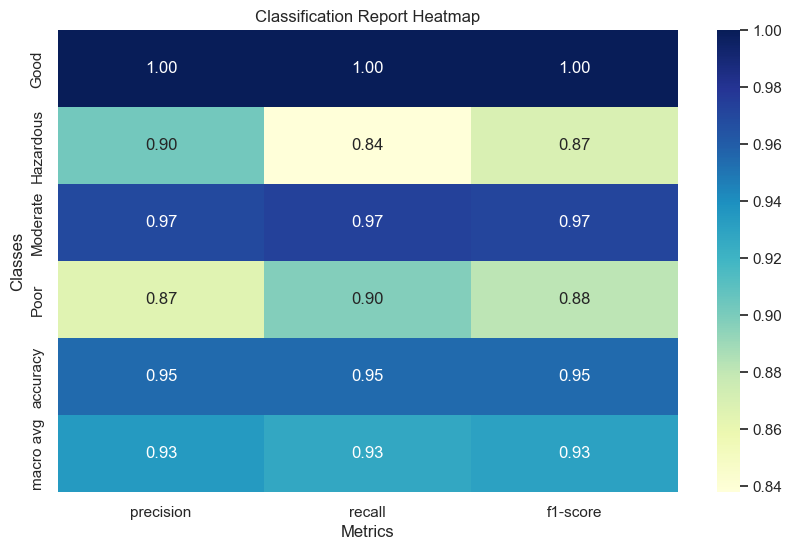

In [207]:
# Generate the classification report as a dictionary
report = classification_report(y_test, y_test_pred, target_names=le.classes_, output_dict=True)

# Convert the report into a DataFrame for visualization
report_df = pd.DataFrame(report).T

# Remove support column
if 'support' in report_df.columns:
    report_df = report_df.drop(columns=['support'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :], annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

In [206]:
# Save the best model
best_model_path = r"C:\Users\User\ml-zoomcamp\capstone_1\models\best_model.pkl"
joblib.dump(best_catboost_model, best_model_path)
print(f"Best Model saved at: {best_model_path}")

# Save the processed datasets for reproducibility during inference
X_train_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\X_train.pkl"
X_val_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\X_val.pkl"
X_test_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\X_test.pkl"
y_train_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\y_train.pkl"
y_val_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\y_val.pkl"
y_test_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\y_test.pkl"

joblib.dump(X_train_scaled, X_train_path)
joblib.dump(X_val_scaled, X_val_path)
joblib.dump(X_test_scaled, X_test_path)
joblib.dump(y_train, y_train_path)
joblib.dump(y_val, y_val_path)
joblib.dump(y_test, y_test_path)

print("Processed datasets saved successfully in:", processed_data_folder)   

# Save the best parameters and metrics for reproducibility during inference
best_params_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_params.pkl"
best_f1_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_f1.pkl"
joblib.dump(best_model_params, best_params_path)
joblib.dump(best_model_f1, best_f1_path)

print(f"Best Parameters saved at: {best_params_path}")
print(f"Best F1-Score saved at: {best_f1_path}")

print("Best parameters and metrics saved successfully in:", processed_data_folder)

Best Model saved at: C:\Users\User\ml-zoomcamp\capstone_1\models\best_model.pkl
Processed datasets saved successfully in: C:\Users\User\ml-zoomcamp\capstone_1\data\processed
Best Parameters saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_params.pkl
Best F1-Score saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_f1.pkl
Best parameters and metrics saved successfully in: C:\Users\User\ml-zoomcamp\capstone_1\data\processed
